In the data preparation phase of this notebook, I performed several steps to clean and preprocess the dataset, including converting timestamps, handling missing and bad values, and encoding categorical variables. The purpose of this notebook is to build and evaluate regression models to predict delivery duration using the provided dataset. This project aims to analyze and predict DoorDash delivery durations, which can help in optimizing delivery times and improving customer satisfaction.

# Delivery Duration Prediction (Stratascratch)

In [1]:
%pip install category_encoders

from IPython.display import Markdown, display

import pandas as pd
import numpy as np
np.random.seed(42)
rng = np.random.default_rng(42)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from pathlib import Path
data_path = Path('./data')
from sklearn.impute import KNNImputer
from category_encoders import TargetEncoder
import warnings
warnings.filterwarnings("ignore")

Note: you may need to restart the kernel to use updated packages.


# Load Data

In [2]:
# Load data
df = pd.read_csv(data_path /'historical_data.csv')

In [3]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

# Data Preperation

In [5]:
# Convert timestamps
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

In [6]:
# Create target variable
df['total_delivery_duration_seconds'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()

In [7]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration_seconds
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


In [ ]:
# Fill missing store_primary_category values with the mode grouped by store_id
df['store_primary_category'] = df.groupby('store_id')['store_primary_category'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'unknown'))


# Check if any store_id has more than one store_primary_category
store_category_counts = df.groupby('store_id')['store_primary_category'].nunique()

# Filter store_ids with more than one unique store_primary_category
store_ids_with_multiple_categories = store_category_counts[store_category_counts > 1].index.tolist()

# For each store_id with multiple categories, replace the less frequent categories with the most frequent one
for store_id in store_ids_with_multiple_categories:
    most_frequent_category = df[df['store_id'] == store_id]['store_primary_category'].mode()[0]
    df.loc[df['store_id'] == store_id, 'store_primary_category'] = most_frequent_category

# Verify the changes
df[['store_id', 'store_primary_category']].drop_duplicates()
        

,store_id,store_primary_category
0,1845,american
1,5477,indian
14,2841,italian
19,4139,mexican
21,5058,italian
...,...,...
197213,1340,italian
197290,6110,italian
197342,215,italian
197347,2956,fast


In [9]:
df['store_primary_category'].isna().sum()

0

In [10]:
# Fill missing values
# Get categorical features with missing values
categorical_features_with_na = df.select_dtypes(include=['object']).columns[df.select_dtypes(include=['object']).isnull().any()].tolist()

# Get numeric features with missing values
numeric_features_with_na = df.select_dtypes(include=[np.number]).columns[df.select_dtypes(include=[np.number]).isnull().any()].tolist()

In [11]:
# Initialize the KNNImputer
imputer = KNNImputer(n_neighbors=3)

# Impute missing values
df[numeric_features_with_na] = imputer.fit_transform(df[numeric_features_with_na])


# For categorical features, fill missing values with mode
for col in categorical_features_with_na:
    df[col] = df[col].fillna(df[col].mode()[0])

In [12]:
# Drop rows with missing actual_delivery_time
df = df.dropna(subset=['actual_delivery_time'])

# Verify the changes
df.isna().sum()

market_id                                       0
created_at                                      0
actual_delivery_time                            0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
total_delivery_duration_seconds                 0
dtype: int64

In [13]:
# Feature Engineering
# Extracting more date and time features
df['created_at_weekday'] = df['created_at'].dt.weekday
df['created_at_weekofyear'] = df['created_at'].dt.isocalendar().week


# Calculate the average item price
df['avg_item_price'] = df['subtotal'] / df['total_items']

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197421 entries, 0 to 197427
Data columns (total 20 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     197421 non-null  float64       
 1   created_at                                    197421 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197421 non-null  int64         
 4   store_primary_category                        197421 non-null  object        
 5   order_protocol                                197421 non-null  float64       
 6   total_items                                   197421 non-null  int64         
 7   subtotal                                      197421 non-null  int64         
 8   num_distinct_items                            197421 non-nu

In [15]:
# Initialize the target encoder
target_encoder = TargetEncoder()

# Apply target encoding to the 'store_primary_category' column
df['store_primary_category'] = target_encoder.fit_transform(df['store_primary_category'], df['total_delivery_duration_seconds'])

# Display the first few rows of the dataframe with the encoded column
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration_seconds,created_at_weekday,created_at_weekofyear,avg_item_price
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,2870.715556,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,4,6,860.25
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,2989.596156,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1,7,1900.00
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,2989.596156,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,3,4,1900.00
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,2989.596156,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1,6,1150.00
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,2989.596156,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,6,7,1300.00


In [16]:
# Save Cleaned Data
df.to_csv(data_path / 'cleaned_historical_data.csv', index=False)

### Visualization

#### Univariate Analysis

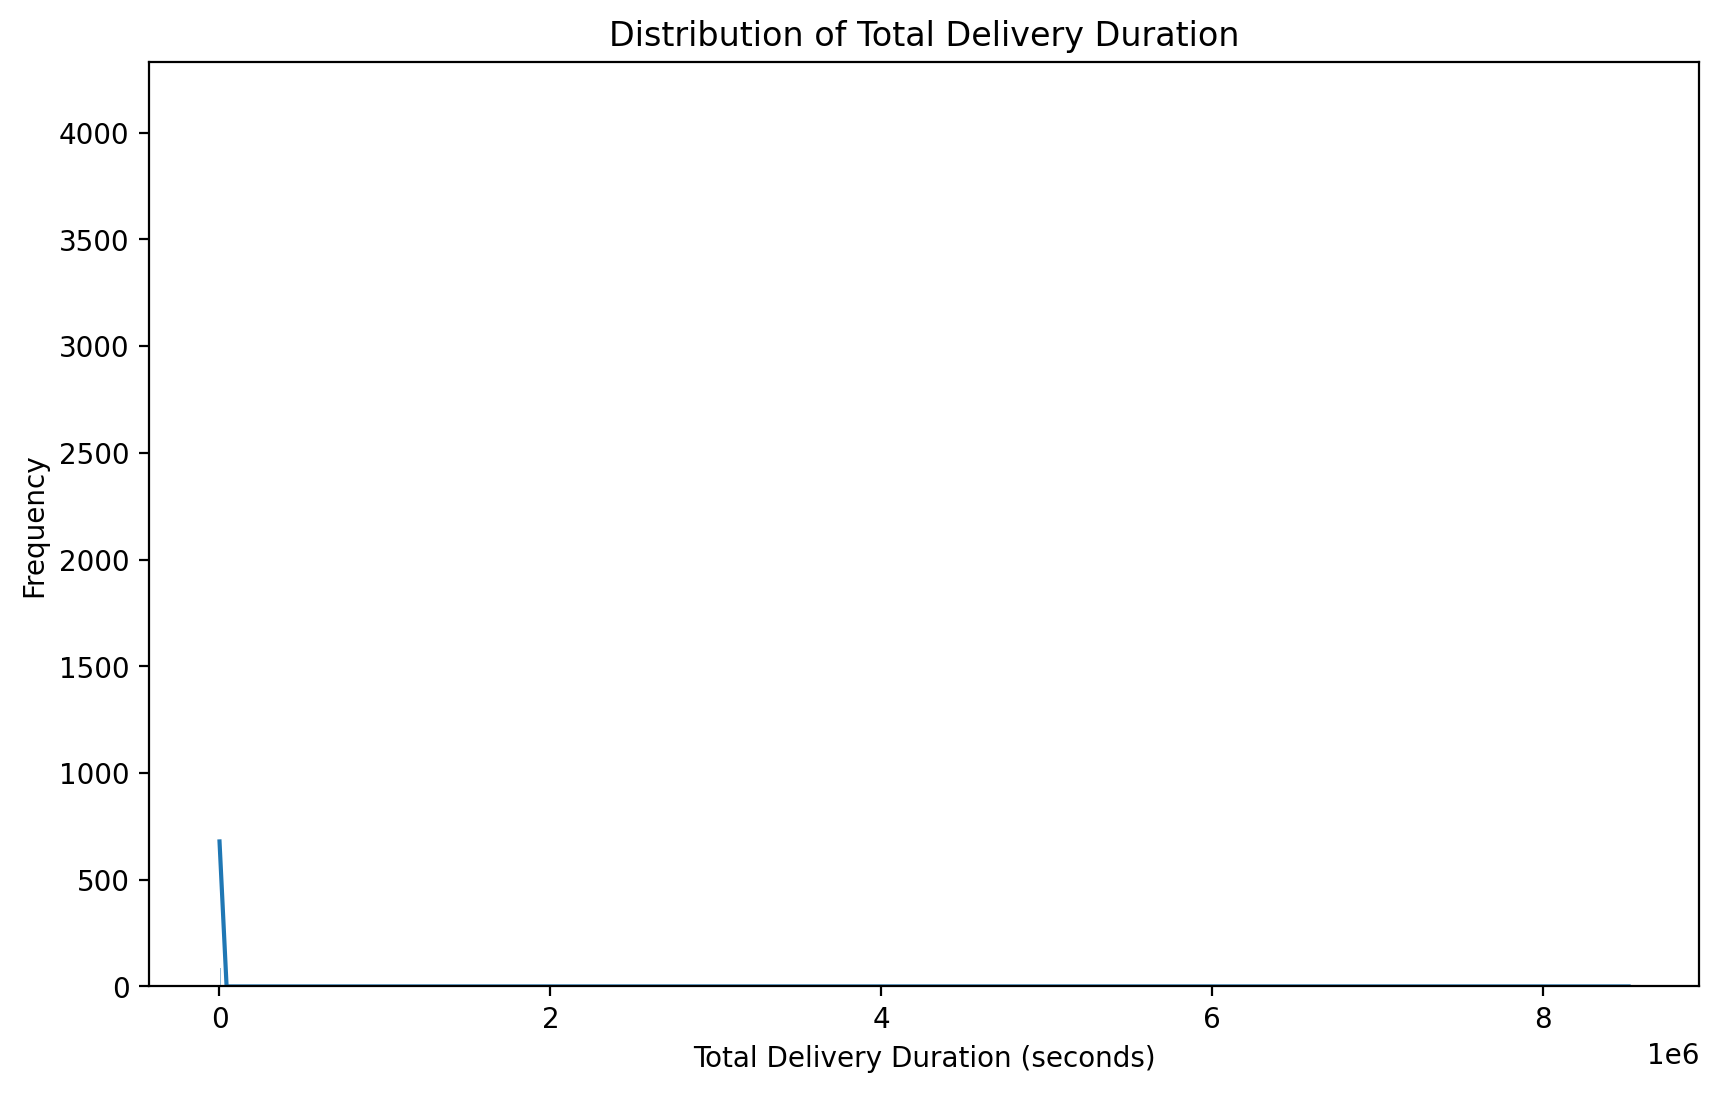

In [17]:
# Histogram of total delivery duration
plt.figure(figsize=(10, 6))
sns.histplot(df['total_delivery_duration_seconds'], kde=True)
plt.title('Distribution of Total Delivery Duration')
plt.xlabel('Total Delivery Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

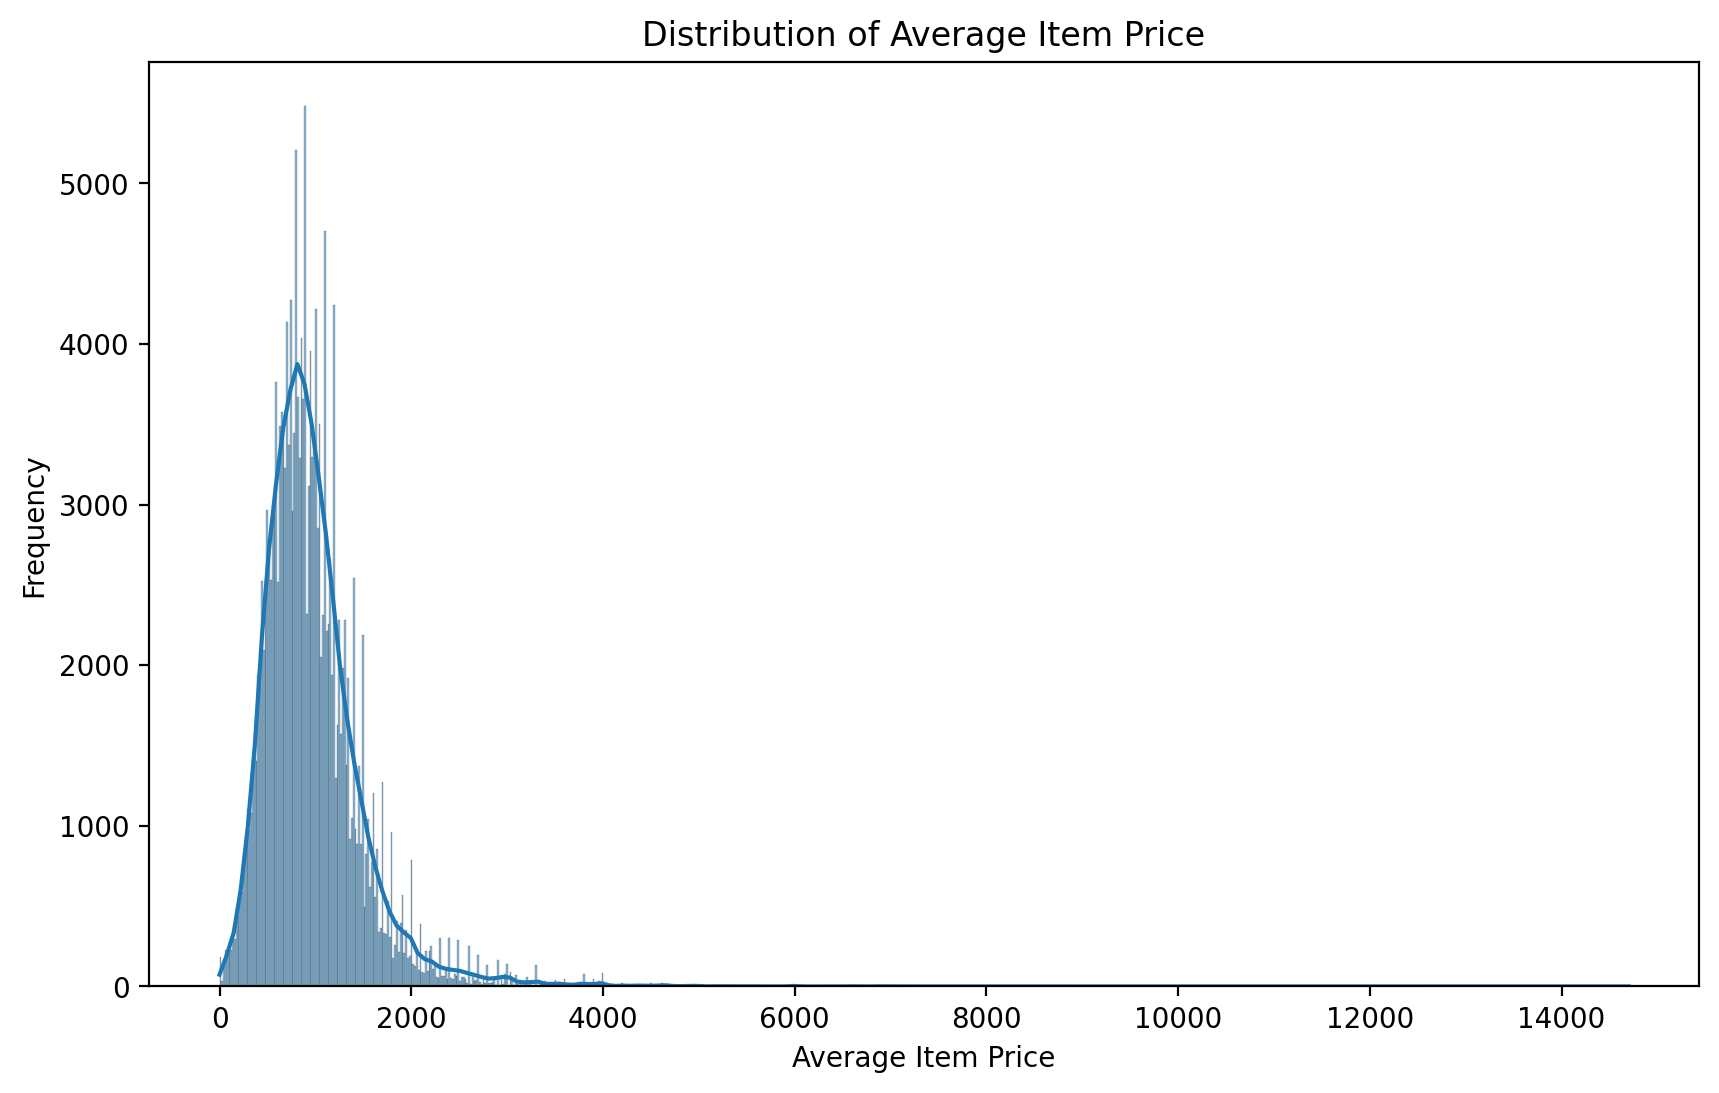

In [24]:
# Distribution of the average item price
plt.figure(figsize=(10, 6))
sns.histplot(df['avg_item_price'], kde=True)
plt.title('Distribution of Average Item Price')
plt.xlabel('Average Item Price')
plt.ylabel('Frequency')
plt.show()

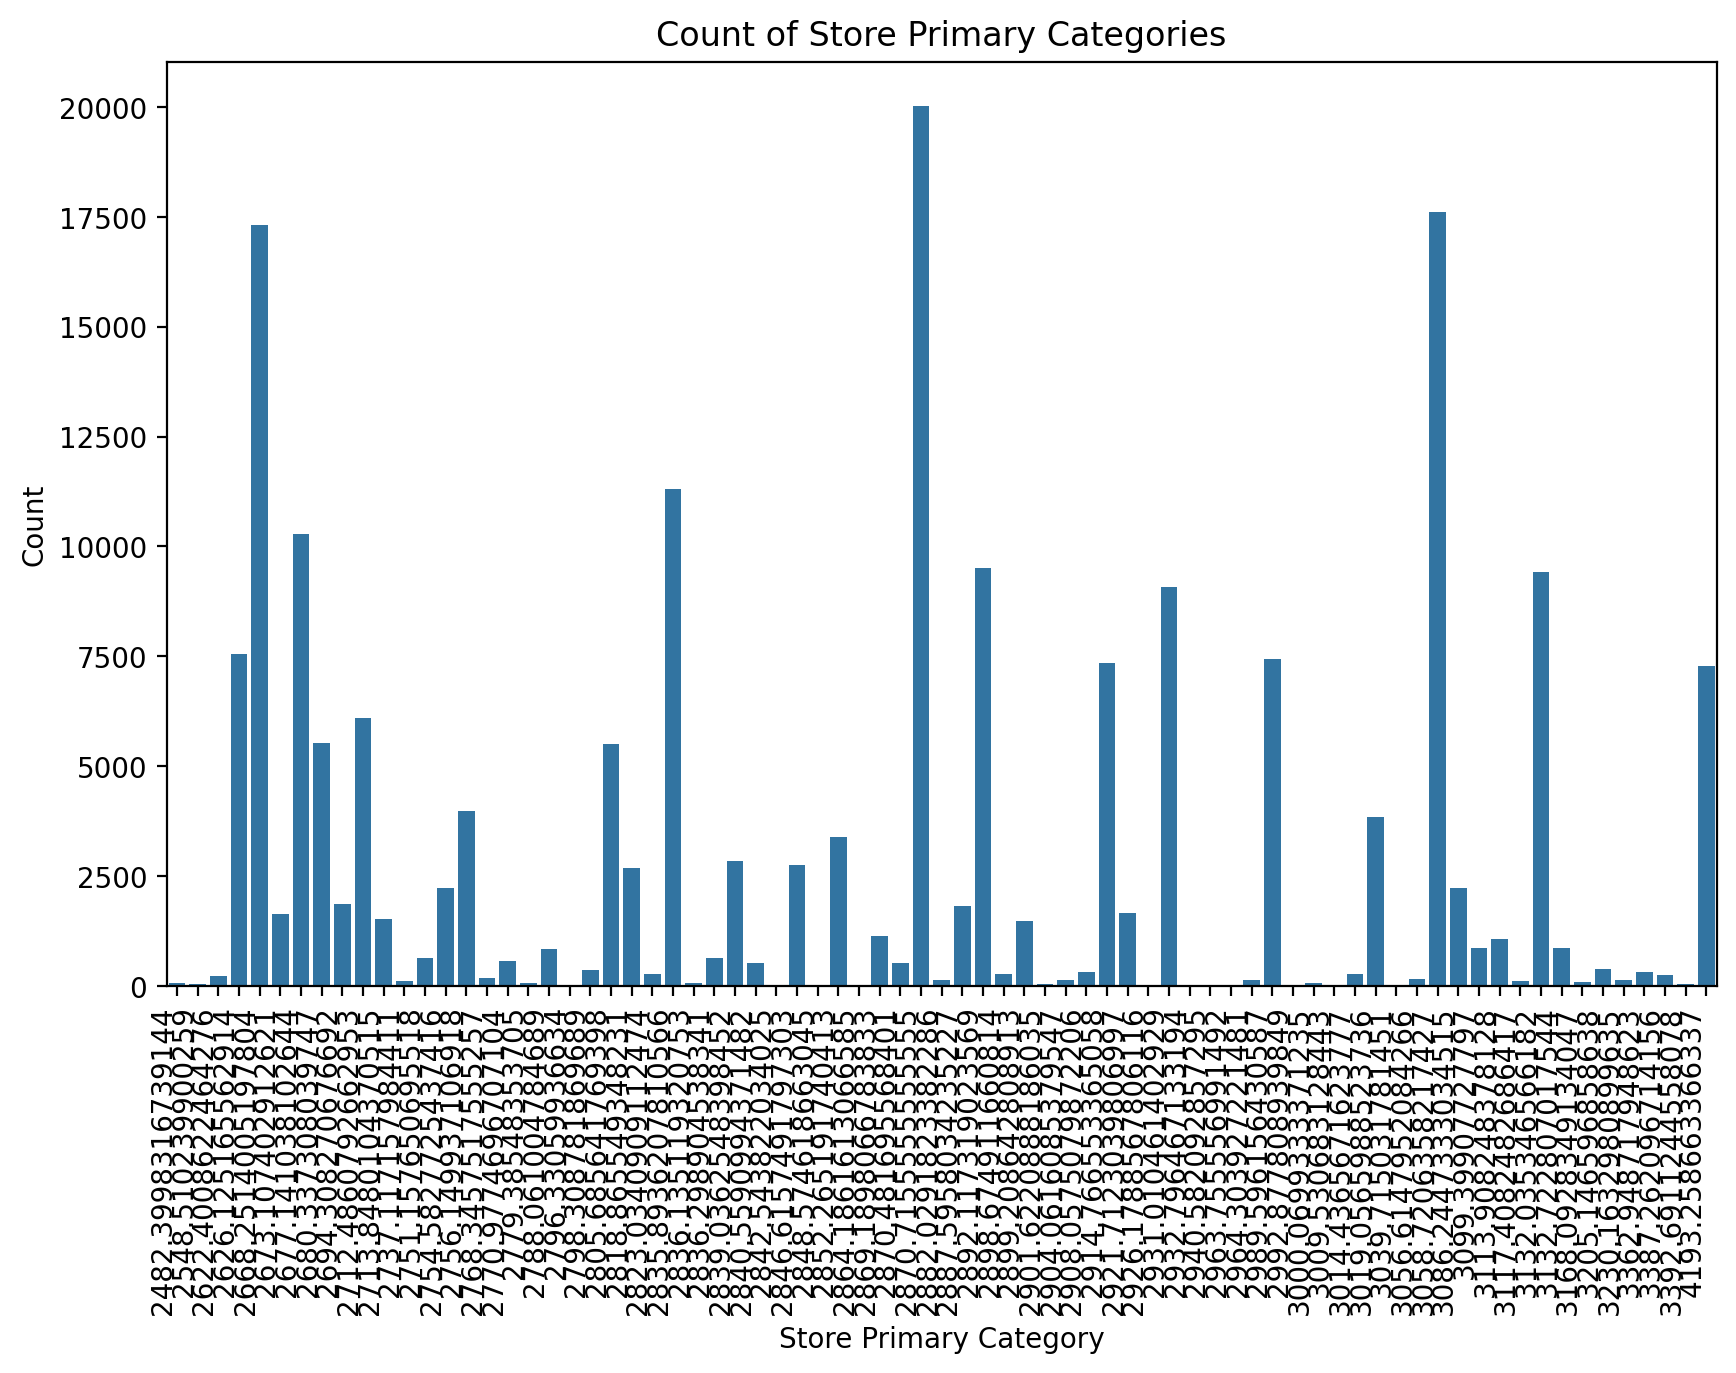

In [18]:
# Count plot of store primary category
plt.figure(figsize=(10, 6))
sns.countplot(x='store_primary_category', data=df)
plt.title('Count of Store Primary Categories')
plt.xlabel('Store Primary Category')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')
plt.show()

### Multivariate analysis


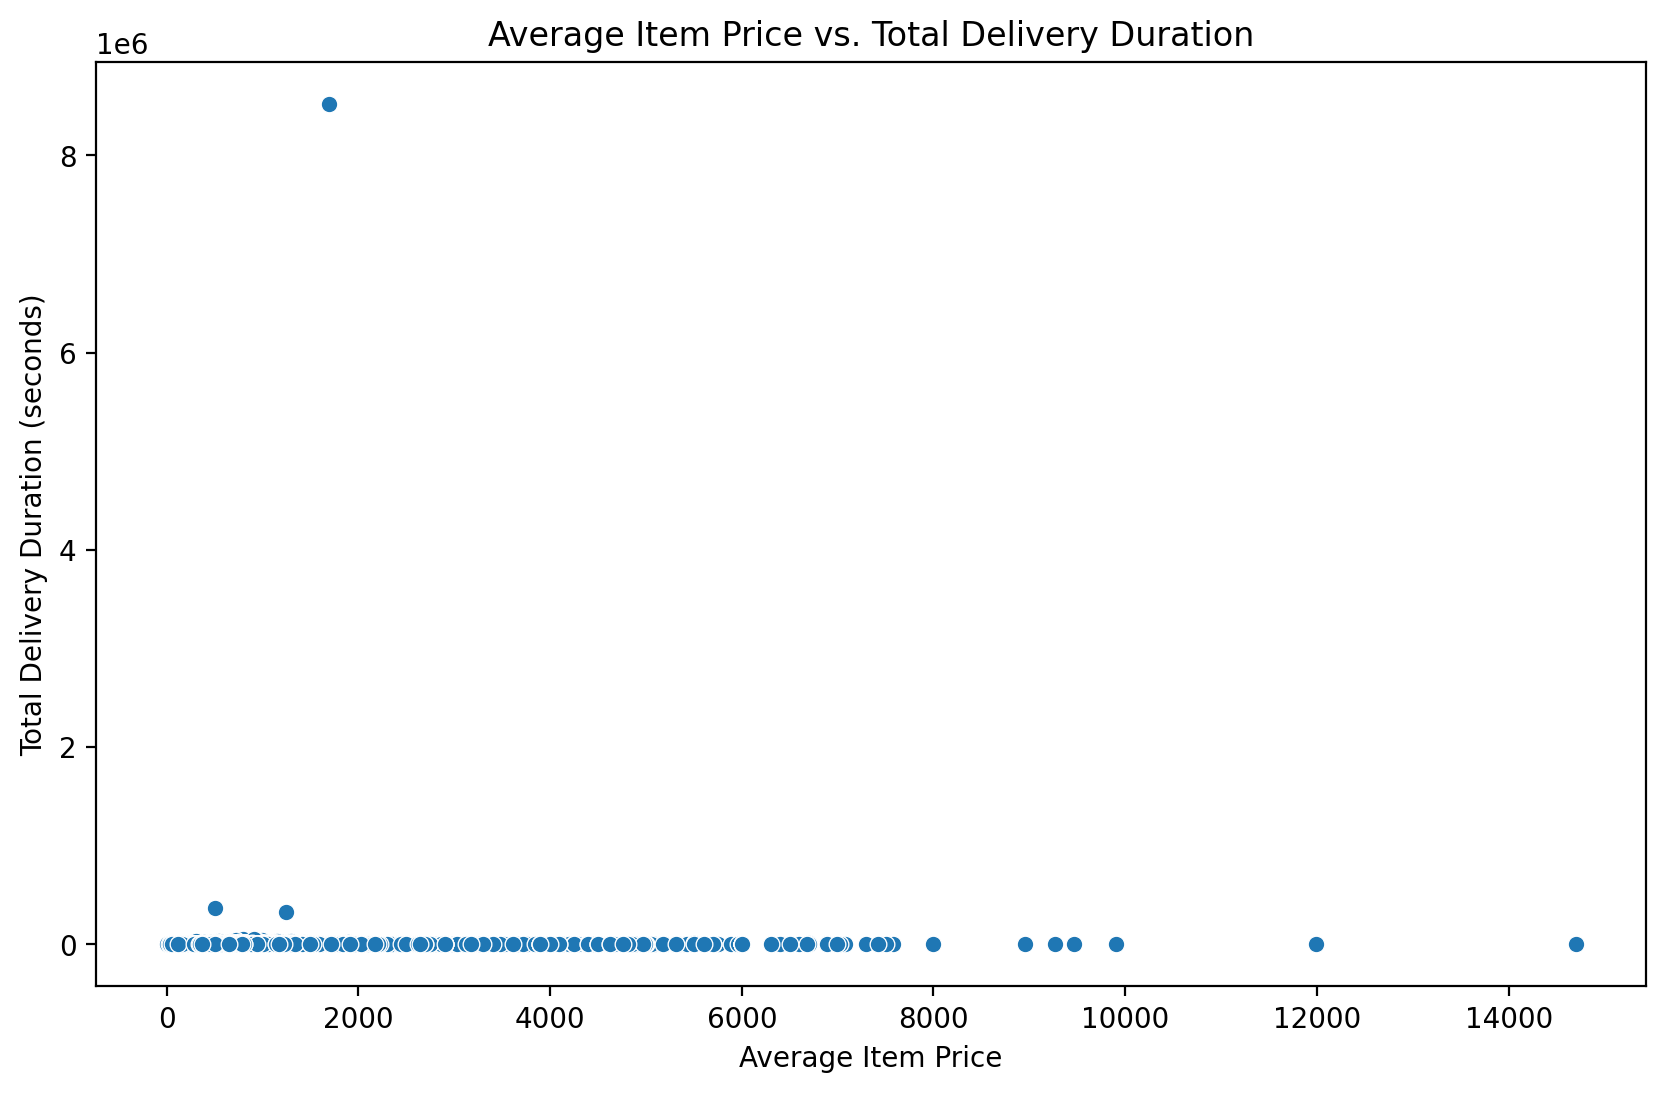

In [19]:
# Scatter plot of average item price vs. total delivery duration
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_item_price', y='total_delivery_duration_seconds', data=df)
plt.title('Average Item Price vs. Total Delivery Duration')
plt.xlabel('Average Item Price')
plt.ylabel('Total Delivery Duration (seconds)')
plt.show()

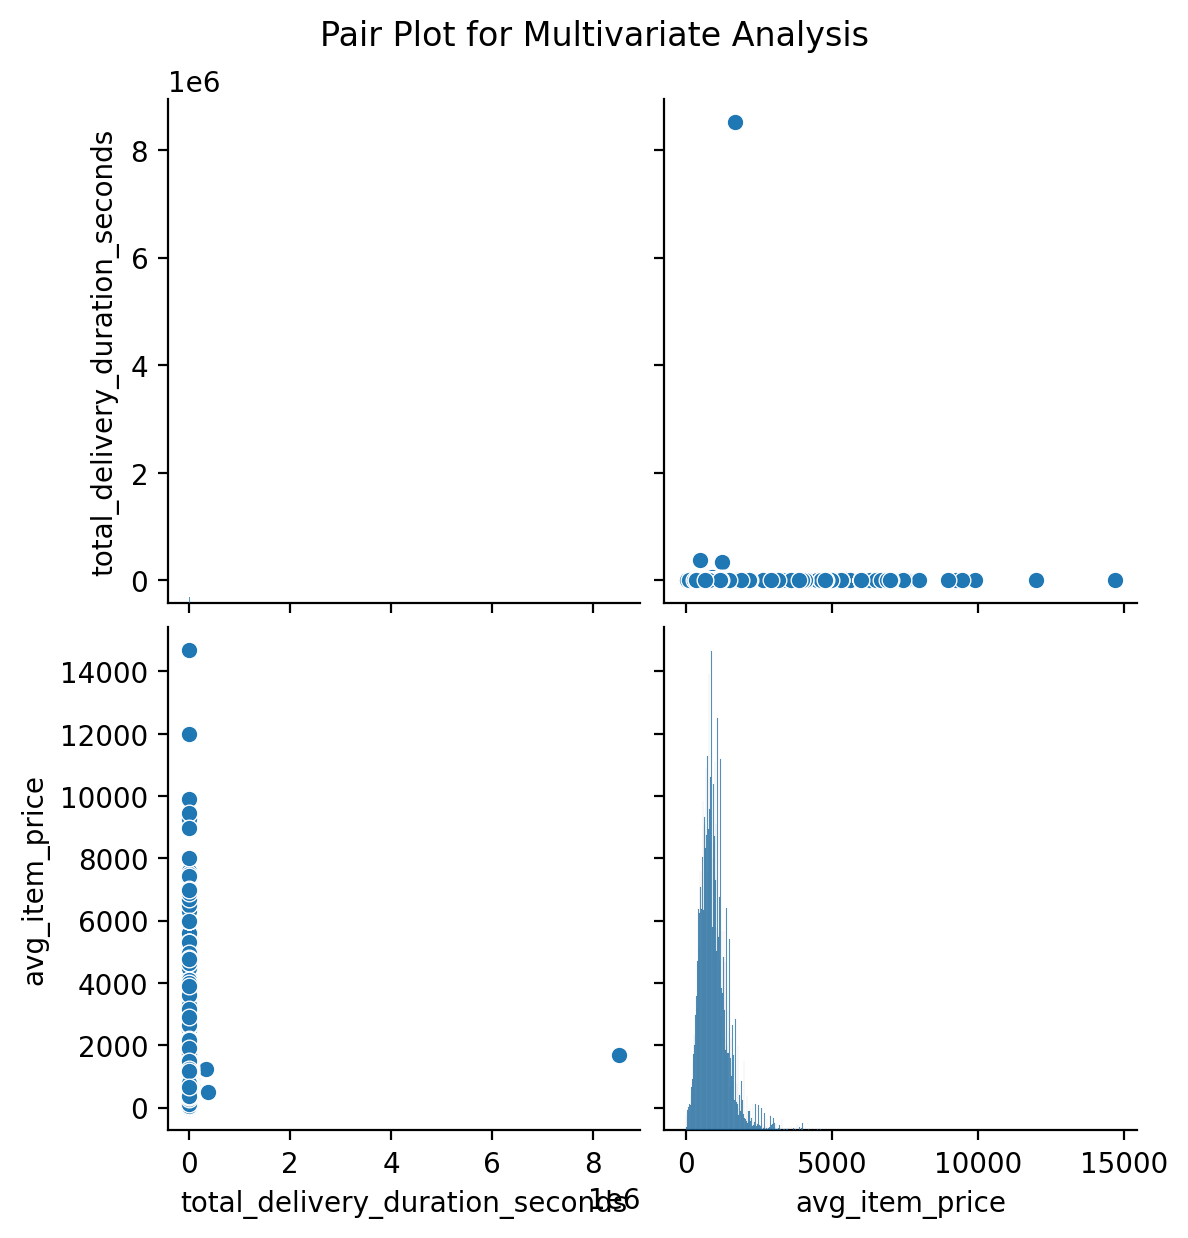

In [30]:
# Pair plot for multivariate analysis
sns.pairplot(df[['total_delivery_duration_seconds', 'avg_item_price']], height=3, aspect=1)
plt.suptitle('Pair Plot for Multivariate Analysis', y=1.02)
plt.show()

### Check for multicollinearity

In [31]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration_seconds,created_at_weekday,created_at_weekofyear,avg_item_price
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,2870.715556,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,4,6,860.25
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,2989.596156,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1,7,1900.00
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,2989.596156,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,3,4,1900.00
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,2989.596156,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1,6,1150.00
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,2989.596156,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,6,7,1300.00


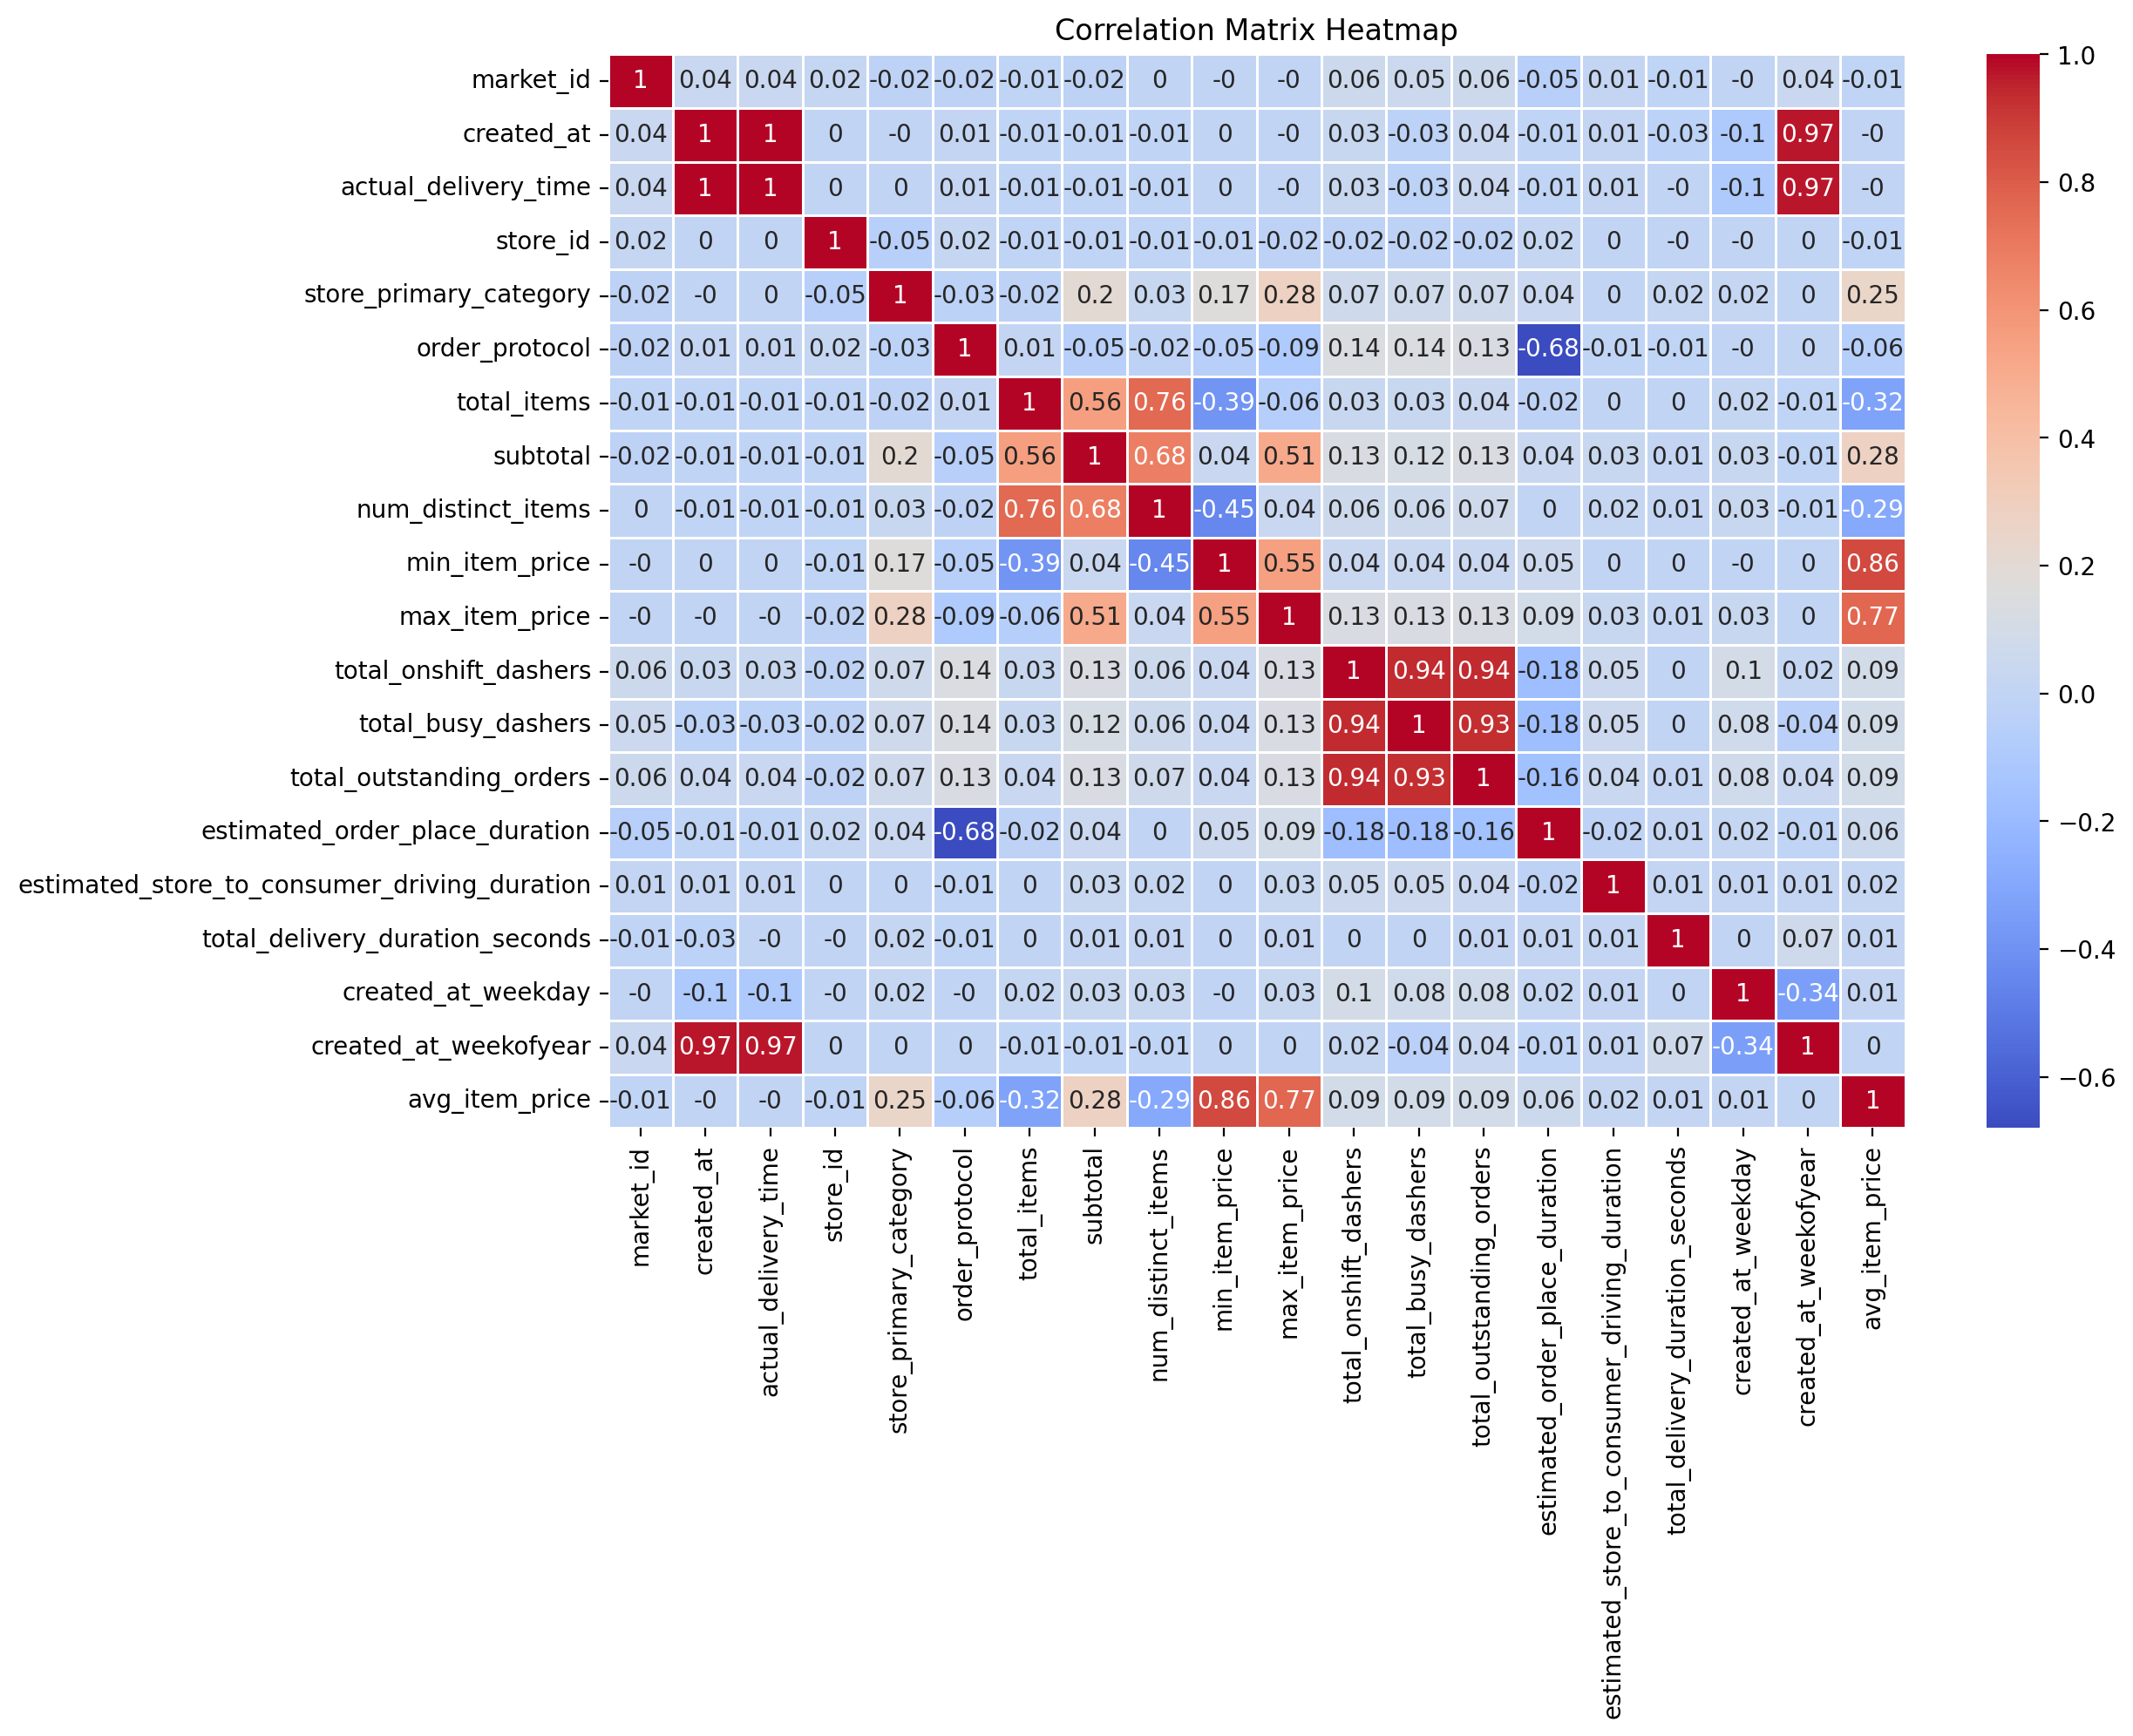

In [23]:
# Calculate the correlation matrix for all numeric features
corr_matrix = df.corr().round(2)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

The correlation matrix heatmap reveals relationships between variables, with red indicating positive and blue indicating negative correlations.

- The diagonal line shows perfect positive correlation (1) for each variable with itself.
- Variables like `market_id`, `store_id`, `estimated_store_to_consumer_driving_duration`, and `total_delivery_duration_seconds` have low correlation with others.

### High Positive Correlations
- `created_at` and `actual_delivery_time`: 1.00
- `total_onshift_dashers` and `total_busy_dashers`: 0.94
- `total_onshift_dashers` and `total_outstanding_orders`: 0.94
- `total_busy_dashers` and `total_outstanding_orders`: 0.93
- `total_items` and `num_distinct_items`: 0.76
- `min_item_price` and `avg_item_price`: 0.86
- `max_item_price` and `avg_item_price`: 0.77

### High Negative Correlations
- `order_protocol` and `estimated_order_place_duration`: -0.68
- `total_items` and `min_item_price`: -0.39
- `num_distinct_items` and `min_item_price`: -0.45
- `total_items` and `avg_item_price`: -0.32
- `num_distinct_items` and `avg_item_price`: -0.29

To avoid overfitting, we should consider removing one of the highly correlated features from the model.
- Remove either `created_at` or `actual_delivery_time` since they are perfectly correlated.
- Remove either `total_onshift_dashers`, `total_busy_dashers`, or `total_outstanding_orders` as they are highly correlated with each other.
- Remove either `min_item_price` or `max_item_price` since they are strongly correlated with `avg_item_price`.
